# **Intro linear latent space arithmetic PCA**
In this notebook I use a PCA in order to predict the gene expression changes induced by a perturbation.
Here, we want to know the cell-type specific perturbation effect.
We use unperturbed single-cell and pert+unpert bulk in order to infer the cell-type specific expressiom change.
To do this, we use latent space arithmetic, where the latent space is the PCA space. 





# **Imports**

In [1]:
# general imports
import warnings
import numpy as np
import scanpy as sc
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [56]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)

<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../buddi/plotting/validation_plotting.py'>

In [53]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_liver_data/"
bulk_aug_data_path = f"{os.getcwd()}/../../data/bulk_data/liver_sex/"
reference_data_path = f"{os.getcwd()}/../../data/reference_data/"
res_data_path = f"{os.getcwd()}/../../results/single_cell_data/bp_liver/"

de_genes_path = f"{os.getcwd()}/../../data/single_cell_data/liver_sex/de_pseudobulk_results.pkl"
de_bulk_path = f"{os.getcwd()}/../../data/bulk_data/liver_sex/de_real_bulk_results.pkl"


cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_liver/"


cibersort_genes_path = (f"{os.getcwd()}/../../results/single_cell_data/cibersort_liver/" +
                        "CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_refsample.bm.K999.txt")

# bp results
bp_res_path = f"{os.getcwd()}/../../results/single_cell_data/bp_liver/"


num_genes = 7000

exp_id = "all-liver"

# Set-up experimental variables

In [4]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8

# number of patients/domains/samples expected
n_tot_samples = 51 # 3 "patients", old / young

# number of drugs (one-hot encoded)
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_bulk = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [5]:
in_name = "liver_bulk_processed"


# read in the real bulk data
processed_sc_file = f"{bulk_aug_data_path}/{in_name}.h5ad"
adata = sc.read_h5ad(processed_sc_file)


# now get the sc ref training data

# read in male first
sample_order = ['30-M-5']

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_liver_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

# now read in female
sample_order = ['18-F-51']
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_liver_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Test", exp_id)
    pseudobulks_df.columns = gene_df

    X_concat = pd.concat([X_concat, pseudobulks_df])
    Y_concat = pd.concat([Y_concat, prop_df])
    meta_concat = pd.concat([meta_concat, metadata_df])



# read in the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)


# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(15)]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])


# format the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(real_bulk_df.shape[0])]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])



30-M-5
18-F-51


<ipython-input-5-87ecae84aa3b>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["isTraining"] = "Train"
<ipython-input-5-87ecae84aa3b>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["cell_prop_type"] = "realistic"
<ipython-input-5-87ecae84aa3b>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [6]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)



# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6455)[-6455:] # num_genes # 6679
gene_df = gene_df.iloc[idx_top]


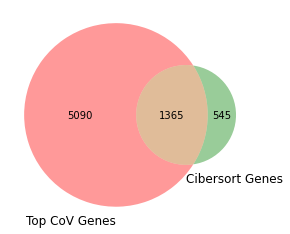

In [7]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [8]:
union_genes = np.union1d(gene_df, cibersort_genes)


# Normalize input data

In [9]:
X_full = X_full.loc[:,union_genes]


## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()





In [10]:
X_train

array([[8.720e+02, 1.405e+03, 3.900e+01, ..., 1.099e+03, 9.900e+02,
        1.100e+01],
       [2.450e+03, 2.258e+03, 3.100e+01, ..., 7.050e+02, 1.023e+03,
        1.100e+01],
       [1.764e+03, 1.915e+03, 6.400e+01, ..., 1.484e+03, 9.640e+02,
        0.000e+00],
       ...,
       [0.000e+00, 4.000e+00, 0.000e+00, ..., 6.400e+01, 6.200e+01,
        0.000e+00],
       [6.000e+00, 5.200e+01, 7.000e+00, ..., 9.700e+01, 7.700e+01,
        0.000e+00],
       [3.246e+03, 3.130e+02, 2.200e+01, ..., 5.650e+02, 4.040e+02,
        1.000e+00]])

In [61]:
X_train.shape

(1849, 12618)

# Read in BP data

In [11]:

def read_bp_result_file(res_path):
    res_file = os.path.join(res_path, "bp_expr.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


In [22]:

# read in BP
bp_df  = read_bp_result_file(bp_res_path)
bp_df

,Sox17,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Rrs1,Adhfe1,Vcpip1,Sgk3,...,Fyco1,Cxcr6,Xcr1,Ccr1,Ccr3,Ccr2,Ccr5,Ppp2r3d,cell_type,sample_id
0,0.000,0.568,0.056,0.124,0.096,0.088,0.052,0.272,0.036,0.032,...,0.024,0.000,0.000,0.000,0.004,0.000,0.000,0.004,hepatocyte,Liver_56
1,0.000,0.036,0.000,0.004,0.012,0.020,0.000,0.036,0.012,0.004,...,0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.008,hepatocyte,Liver_46
2,0.136,5052.336,422.056,1149.368,721.844,2468.152,168.428,2231.936,597.760,264.600,...,755.988,31.724,6.328,0.536,0.024,0.172,0.204,24.228,hepatocyte,Liver_8
3,0.100,3207.952,283.684,642.720,596.264,1518.176,194.560,1551.128,339.580,123.076,...,414.920,6.160,3.628,0.176,0.132,0.100,0.120,31.152,hepatocyte,Liver_14
4,0.120,3379.948,365.076,680.516,561.008,1746.408,365.656,1648.860,529.584,214.396,...,391.212,35.224,9.604,0.824,0.000,0.132,0.204,32.628,hepatocyte,Liver_9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,0.296,18.196,18.132,28.584,19.192,10.336,7.576,2.004,26.404,57.836,...,10.808,0.612,200.324,18.656,0.060,82.968,1.976,1.492,myeloid_leukocyte,Liver_7
388,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,...,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.000,myeloid_leukocyte,Liver_35
389,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,myeloid_leukocyte,Liver_2
390,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,myeloid_leukocyte,Liver_5


In [23]:
# get meta data
meta_bp_df = bp_df[["cell_type", "sample_id"]]
ref_meta_df = meta_df.copy()

# right join to maintain order 
meta_bp_df = ref_meta_df.merge(meta_bp_df, how='right', on='sample_id')

# Y_max no longer matters for this BP sample, this is referencing the cell_type
meta_bp_df["Y_max"] = meta_bp_df["cell_type"]

# this is also all going to be used in our testing
meta_bp_df["isTraining"] = "Test"


# get the overlapping genes
bp_union_genes = np.intersect1d(bp_df.columns, union_genes) 

# subset to union genes
bp_df = bp_df.loc[:,bp_union_genes]


In [24]:
meta_bp_df

,sample_id,stim,isTraining,cell_prop_type,samp_type,Y_max,cell_type
0,Liver_56,CTRL,Test,realistic,bulk,hepatocyte,hepatocyte
1,Liver_46,CTRL,Test,realistic,bulk,hepatocyte,hepatocyte
2,Liver_8,STIM,Test,realistic,bulk,hepatocyte,hepatocyte
3,Liver_14,CTRL,Test,realistic,bulk,hepatocyte,hepatocyte
4,Liver_9,STIM,Test,realistic,bulk,hepatocyte,hepatocyte
...,...,...,...,...,...,...,...
387,Liver_7,CTRL,Test,realistic,bulk,myeloid_leukocyte,myeloid_leukocyte
388,Liver_35,CTRL,Test,realistic,bulk,myeloid_leukocyte,myeloid_leukocyte
389,Liver_2,STIM,Test,realistic,bulk,myeloid_leukocyte,myeloid_leukocyte
390,Liver_5,CTRL,Test,realistic,bulk,myeloid_leukocyte,myeloid_leukocyte


# **Inspect BP output**

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 392 samples in 0.002s...
[t-SNE] Computed neighbors for 392 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 392 / 392
[t-SNE] Mean sigma: 0.887018
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.689938
[t-SNE] KL divergence after 500 iterations: 0.454901
(392, 2)
(392, 2)


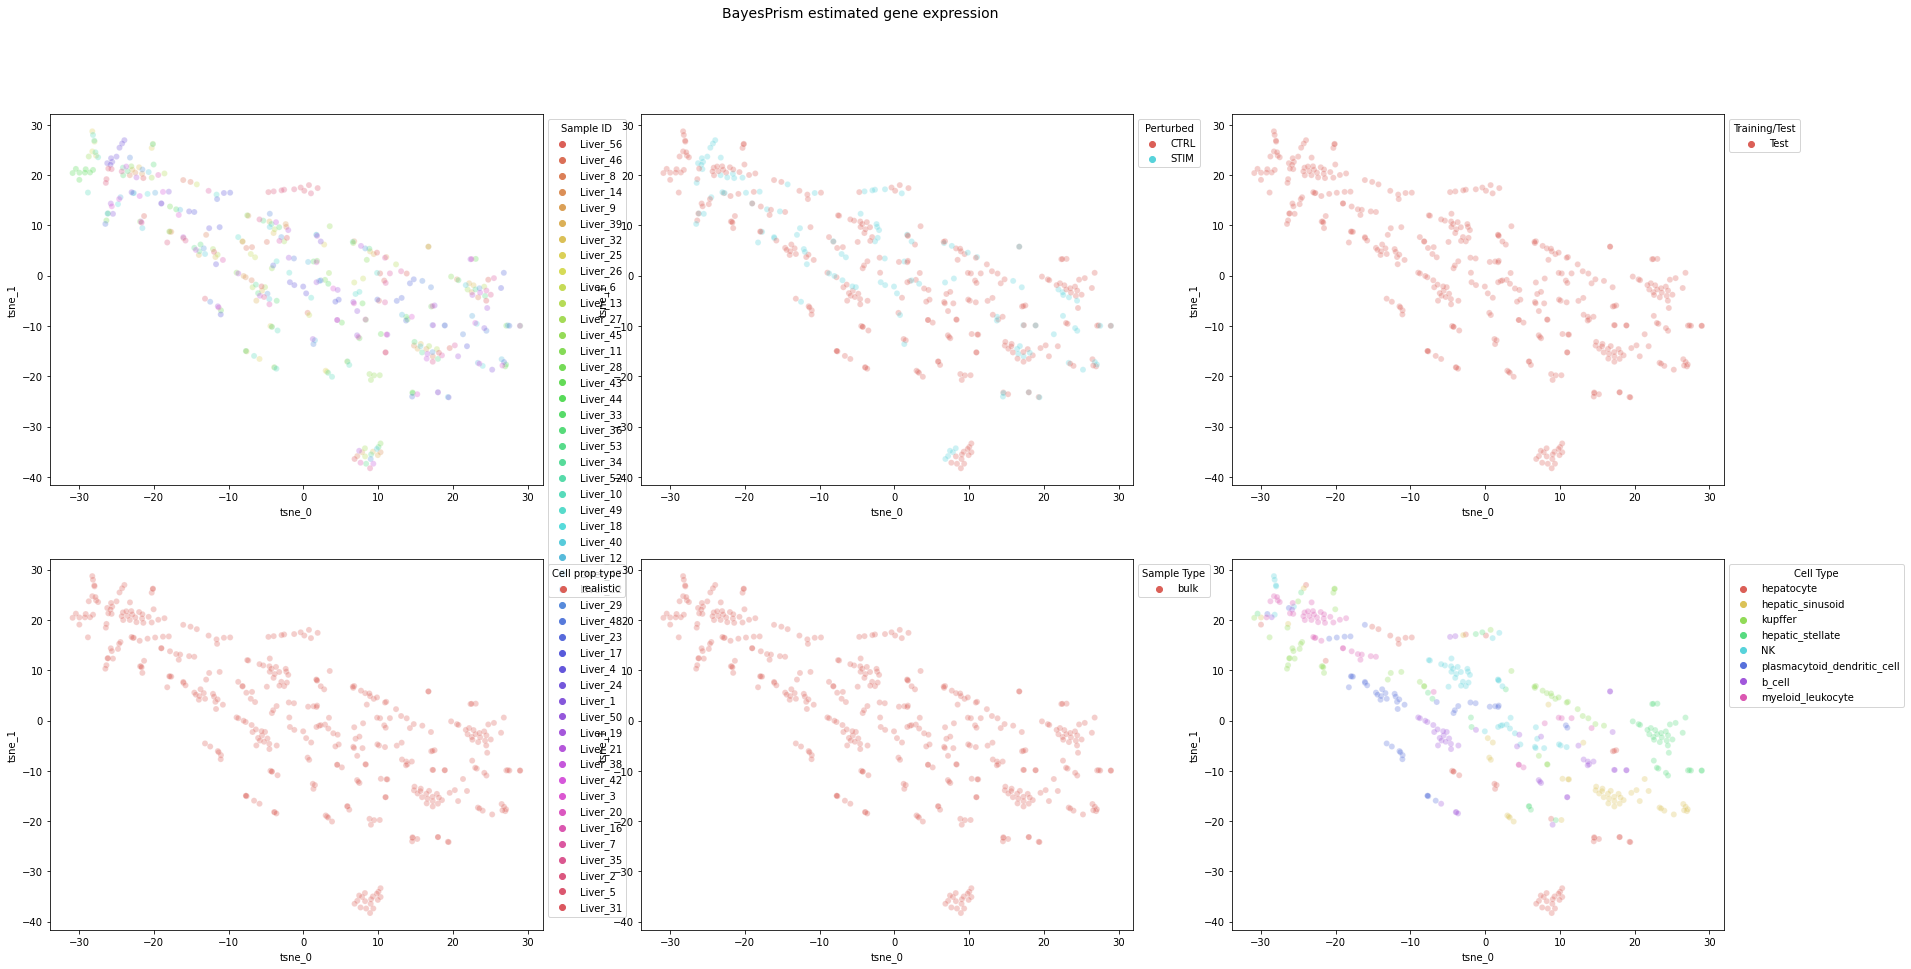

In [25]:
## plot samples
plot_df = vp.get_tsne_for_plotting(bp_df)

fig, axs = plt.subplots(2, 3, figsize=(30,15))


vp.plot_tsne(plot_df, meta_bp_df.sample_id.to_numpy(), axs[0,0], legend_title="Sample ID", title=f"")
vp.plot_tsne(plot_df, meta_bp_df.stim.to_numpy(), axs[0,1], legend_title="Perturbed", title=f"")
vp.plot_tsne(plot_df, meta_bp_df.isTraining.to_numpy(), axs[0,2], legend_title="Training/Test", title=f"")
vp.plot_tsne(plot_df, meta_bp_df.cell_prop_type.to_numpy(), axs[1,0], legend_title="Cell prop type", title=f"")
vp.plot_tsne(plot_df, meta_bp_df.samp_type.to_numpy(), axs[1,1], legend_title="Sample Type", title=f"")
vp.plot_tsne(plot_df, meta_bp_df.cell_type.to_numpy(), axs[1,2], legend_title="Cell Type", title=f"")


fig.suptitle("BayesPrism estimated gene expression", fontsize=14)


fig.show()


(392, 2)
(392, 2)


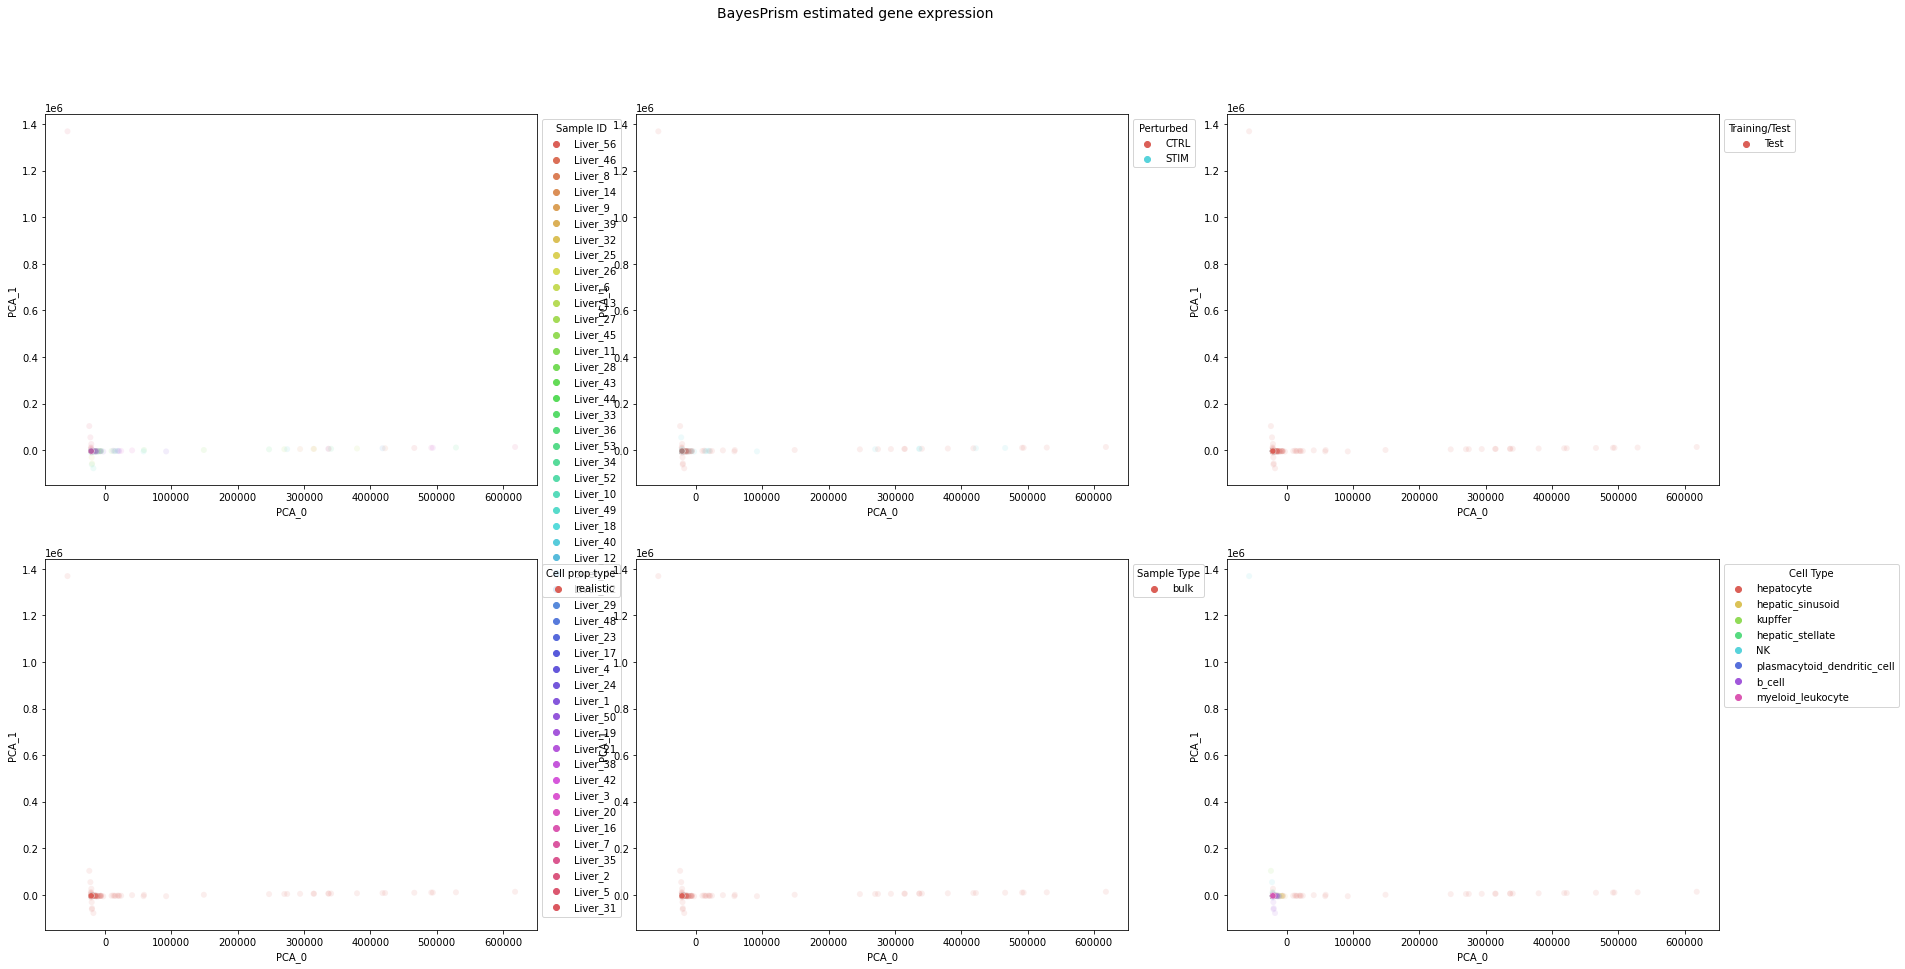

In [26]:
## plot samples
plot_df = vp.get_pca_for_plotting(bp_df)

fig, axs = plt.subplots(2, 3, figsize=(30,15))


vp.plot_pca(plot_df, meta_bp_df.sample_id.to_numpy(), axs[0,0], legend_title="Sample ID", title=f"")
vp.plot_pca(plot_df, meta_bp_df.stim.to_numpy(), axs[0,1], legend_title="Perturbed", title=f"")
vp.plot_pca(plot_df, meta_bp_df.isTraining.to_numpy(), axs[0,2], legend_title="Training/Test", title=f"")
vp.plot_pca(plot_df, meta_bp_df.cell_prop_type.to_numpy(), axs[1,0], legend_title="Cell prop type", title=f"")
vp.plot_pca(plot_df, meta_bp_df.samp_type.to_numpy(), axs[1,1], legend_title="Sample Type", title=f"")
vp.plot_pca(plot_df, meta_bp_df.cell_type.to_numpy(), axs[1,2], legend_title="Cell Type", title=f"")


fig.suptitle("BayesPrism estimated gene expression", fontsize=14)


fig.show()


## Do latent space projections

### drug perturbation

In [27]:

def subset_sample_celltype_perturbation(bp_decoded, 
                                        ctrl_test_meta_df, cell_type_interest=None):


    # get the reconstructed 
    recon_Zstim_idx = np.logical_and(ctrl_test_meta_df.stim == "CTRL", ctrl_test_meta_df.isTraining == "Test")
    if cell_type_interest is not None:
        recon_Zstim_idx = np.logical_and(recon_Zstim_idx, ctrl_test_meta_df.Y_max == cell_type_interest)
    recon_Zstim_idx = np.where(recon_Zstim_idx)[0]
    projected_ctrl = bp_decoded.iloc[recon_Zstim_idx]

    recon_Zstim_idx = np.logical_and(ctrl_test_meta_df.stim == "STIM", ctrl_test_meta_df.isTraining == "Test")
    if cell_type_interest is not None:
        recon_Zstim_idx = np.logical_and(recon_Zstim_idx, ctrl_test_meta_df.Y_max == cell_type_interest)
    recon_Zstim_idx = np.where(recon_Zstim_idx)[0]
    projected_Zstimulated = bp_decoded.iloc[recon_Zstim_idx]


    return (projected_Zstimulated, projected_ctrl)


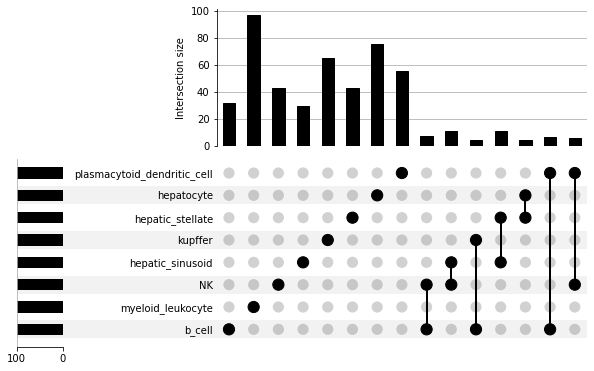

In [29]:
from scipy.stats import rankdata


top_lim = 100

top_genes = {}
de_genes_all = None
for curr_cell_type in Y_full.columns:

    proj_stim, proj_ctrl = subset_sample_celltype_perturbation(bp_df, 
                                                                meta_bp_df, curr_cell_type)


    # take the median for nomalization

    proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
    proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
    proj_log2FC = np.abs(proj_stim-proj_ctrl)

    # make into DF
    proj_log2FC_df = pd.DataFrame(proj_log2FC, index=bp_union_genes)

    intersect_proj = proj_log2FC_df.loc[bp_union_genes][0]
    top_proj_genes = intersect_proj.index[np.argsort(np.abs(intersect_proj))].tolist()[::-1][0:top_lim]

    top_genes[curr_cell_type] = top_proj_genes


cell_diff = from_contents(top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()


In [30]:
top_genes["hepatocyte"]

['Cyp2a4',
 'Ugt2a3',
 'Sec14l2',
 'Hamp2',
 'Ces2a',
 'Cyp2c68',
 'Nags',
 'Aspdh',
 'Bbox1',
 'Sult3a1',
 'Aldh8a1',
 'A1bg',
 'Serpinf2',
 'Bhmt',
 'Cyp2c69',
 'Cyp4f14',
 'Elovl3',
 'Hpd',
 'Cyp2j5',
 'Ces1c',
 'F12',
 'Slc22a26',
 'BC024386',
 'C4bp',
 'Cyp2b9',
 'Cyp2a22',
 'Apoh',
 'Ugt2b36',
 'Acot3',
 'Abcg5',
 'Serpina1b',
 'Ttr',
 'Apoa2',
 'Slc22a27',
 'Aass',
 'Dmgdh',
 'Tat',
 'Hpx',
 'Ugt2b35',
 'Mup3',
 'Hsd17b2',
 'Hsd17b6',
 'Nt5e',
 'Hc',
 'Acnat2',
 'Fitm1',
 'Mcm10',
 'Hao1',
 'Gcgr',
 'Hal',
 'Cyp4a10',
 'Fmo3',
 'Habp2',
 'Esrp2',
 'Cyp3a25',
 'Cyp2b10',
 'Stbd1',
 'Cyp2c70',
 'Gc',
 'Apom',
 'Tm6sf2',
 'Serpina12',
 'Fga',
 'Apol9b',
 'Ociad2',
 'Slc30a10',
 'Klkb1',
 'Tmprss6',
 'Igfbp1',
 'Azgp1',
 'Ugt2b5',
 'Gulo',
 'Pla2g12b',
 'Cyp2a12',
 'Sult2a2',
 'Clstn3',
 'Ttc36',
 'Cldn3',
 'Creb3l3',
 'Cpn1',
 'Ces1g',
 'Mat1a',
 'Serpina1d',
 'Tmem56',
 'Mup12',
 'Adh4',
 'Ido2',
 'Lcat',
 'Sult2a1',
 'F10',
 'Mug1',
 'Cfi',
 'Necab1',
 'Cyp7b1',
 'Agmat',
 'Cyp2d

In [31]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

def plot_effect_size_corr(xval, yval, ax, title, xlab, ylab, class_id, style_id, alpha=0.5):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id,
        alpha= alpha,
        style=style_id
    )
    #g.set(ylim=(min_val, max_val))
    #g.set(xlim=(min_val, max_val))
    #g.plot([min_val, max_val], [min_val, max_val], transform=g.transAxes)
    sns.set_palette("Set2")

    ax.set_title(title)
    return g


### load the single-nucleus DE results from external publication

"Interplay Between GH-regulated, Sex-biased Liver Transcriptome and Hepatic Zonation Revealed by Single-Nucleus RNA Sequencing" 
Christine N Goldfarb, Kritika Karri, Maxim Pyatkov, David J Waxman
Endocrinology, Volume 163, Issue 7, July 2022, bqac059, https://doi.org/10.1210/endocr/bqac059

In [32]:
from gene_lists import load_genelists

union_genes_cap, Pub_DE, Pub_DE_immune, Pub_DE_hepatic, Pub_DE_kupffer, Pub_DE_hsc = load_genelists(bp_union_genes)

### load bulk DE results

In [33]:
de_bulk = pickle.load(open( de_bulk_path, "rb" ))
de_bulk.index = [x.upper() for x in de_bulk.index] 
de_bulk = de_bulk.iloc[np.where(de_bulk.padj < 1)[0]]
intersect_bulk = np.intersect1d(de_bulk.index.to_list(), union_genes_cap)

bulk_sig_df = pd.DataFrame(union_genes_cap, index=union_genes_cap)
bulk_sig_df["padj"] = 1
padj_val = de_bulk.padj[intersect_bulk]
bulk_sig_df.padj.loc[intersect_bulk] = padj_val

bulk_sig_df["log10padj"] = -1*np.log10(bulk_sig_df.padj)

bulk_sig_df["log2FC"] = 1
fc_val = de_bulk.log2FoldChange[intersect_bulk]
bulk_sig_df.log2FC.loc[intersect_bulk] = np.abs(fc_val)

bulk_sig_df

<ipython-input-33-1b0febddcbf6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.padj.loc[intersect_bulk] = padj_val
<ipython-input-33-1b0febddcbf6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.log2FC.loc[intersect_bulk] = np.abs(fc_val)


,0,padj,log10padj,log2FC
A130010J15RIK,A130010J15RIK,1.000000e+00,-0.000000,1.000000
A1BG,A1BG,4.196102e-29,28.377154,8.790101
A1CF,A1CF,1.000000e+00,-0.000000,1.000000
A330009N23RIK,A330009N23RIK,1.000000e+00,-0.000000,1.000000
A430035B10RIK,A430035B10RIK,1.000000e+00,-0.000000,1.000000
...,...,...,...,...
ZSCAN22,ZSCAN22,1.000000e+00,-0.000000,1.000000
ZSCAN29,ZSCAN29,1.000000e+00,-0.000000,1.000000
ZSWIM6,ZSWIM6,1.000000e+00,-0.000000,1.000000
ZYG11B,ZYG11B,1.000000e+00,-0.000000,1.000000


### load single-cell DE genes result

In [34]:
de_genes = pickle.load(open( de_genes_path, "rb" ))
de_genes

{'hepatocyte': ['Ddx5',
  'Rpl37',
  'Apoc3',
  'Aldh2',
  'Fah',
  'BC024386',
  'Idh1',
  'Rps15',
  'Ebpl',
  'Rpl10a',
  'Bst2',
  'Rnasek',
  'Alad',
  'Ndufv1',
  'Prkar1a',
  'Tufm',
  'Bccip',
  'B2m',
  'Crot',
  'Dpys',
  'Ndufa13',
  'Phb2',
  'Rpl8',
  'Eif4a1',
  'Tmem205',
  'Mrps12',
  'Hdlbp',
  'Slc25a13',
  'Gnb2',
  'Rplp1',
  'Eef1d',
  'Rps14',
  'Fau',
  'H2afv',
  'Cox4i1',
  'Cct5',
  'Rnase4',
  'Srsf5',
  'Arl6ip1',
  'Atp5g3',
  'Uqcrc1',
  'Eef2',
  'Rps8',
  'Krt18',
  'Sco2',
  'Rabac1',
  'Gpd1',
  'Pcbp1',
  'R3hdm2',
  'Sumo3',
  'Habp4',
  'Ubc',
  'Pabpc1',
  'Eif3f',
  'Tmem147',
  '2810407C02Rik',
  'Prdx2',
  'Gstt1',
  'Ppib',
  'Eif4a2',
  'Atp5a1',
  'Ccbl2',
  'Serf2',
  'Arf4',
  'Phb',
  'Abhd14b',
  'Znhit1',
  'Tst',
  'Rnf13',
  'Cmtm8',
  'Mtx2',
  'Apoc1',
  'Rab1',
  'Mrpl28',
  'H3f3b',
  'Tmem167',
  'Ran',
  'Lsmd1',
  'Slc25a1',
  'Evi5',
  'Caprin1',
  'Ppdpf',
  'Map1lc3a',
  'Hsp90ab1',
  'Ubxn4',
  'Pgls',
  'Sgk2',
  'Mlf2',
  

### get PR curves and tables

In [35]:
# number of genes from our differential expression analysis
# to be considered top DE

min_overlap = 50

hepatocyte
hepatic_sinusoid
kupffer
hepatic_stellate
NK
b_cell


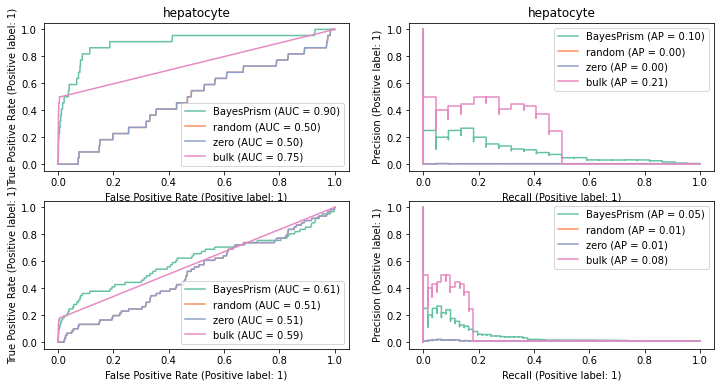

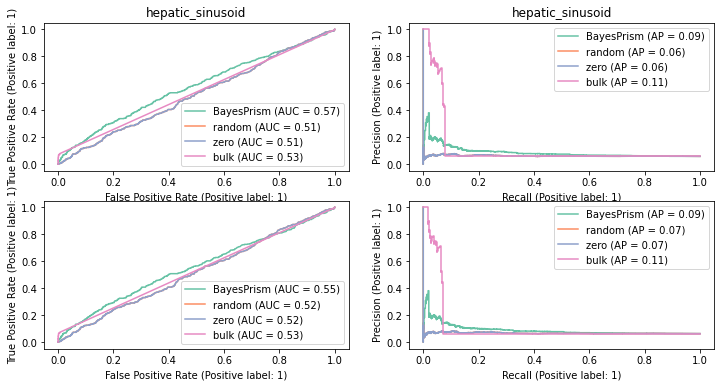

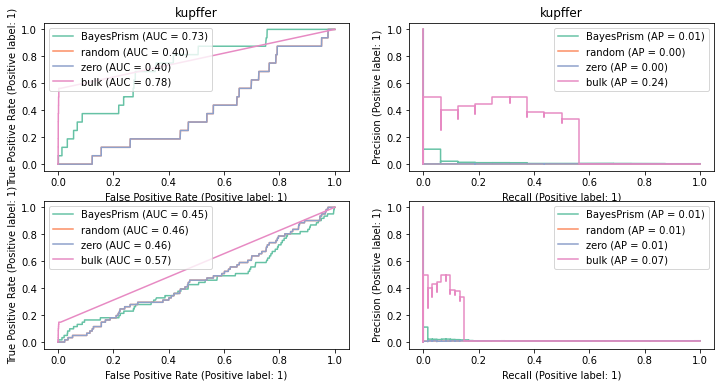

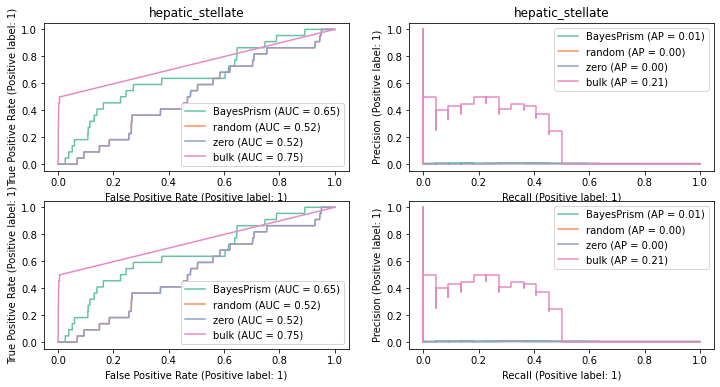

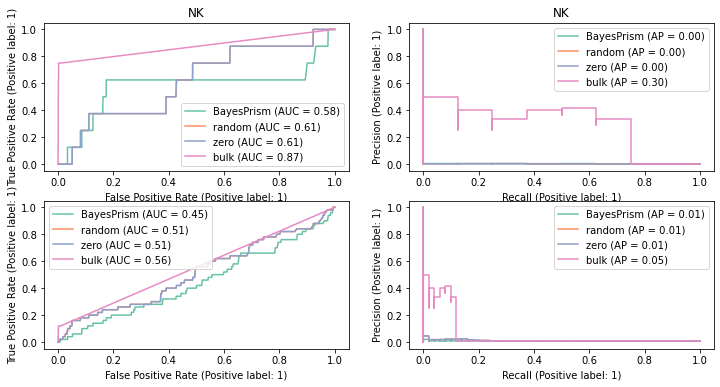

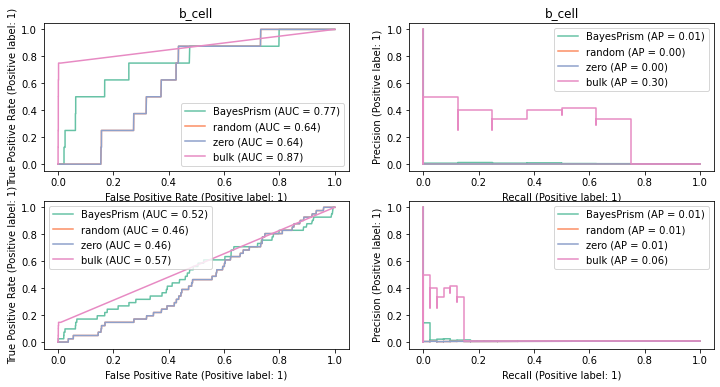

In [57]:

# get PR curve

curr_cell_type = "hepatocyte"
all_cell_types = ["hepatocyte", "hepatic_sinusoid", "kupffer",
                  "hepatic_stellate", "NK", "b_cell"]
all_DE_ref = [Pub_DE_hsc, Pub_DE_hepatic, Pub_DE_kupffer, 
              Pub_DE_hsc, Pub_DE_immune, Pub_DE_immune]


all_res_df = None
curr_idx = 0
for curr_cell_type in all_cell_types:

    print(curr_cell_type)

    # get our DE genes
    de_genes_curr = de_genes[curr_cell_type]
    if de_genes_curr is not None:
        de_genes_curr = [x.upper() for x in de_genes_curr]


    # get bulk DE genes

    # set the reference genes
    DE_ref = Pub_DE
    ct_DE_ref = all_DE_ref[curr_idx]
    extra_ref = ct_DE_ref
    if de_genes_curr is not None:
        extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)


    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs, proj_log2FC_df, res_df = vp.plot_PR_ROC_liver_BP(meta_bp_df, bp_df, 
                                        bulk_sig_df, curr_cell_type, ct_DE_ref, extra_ref, 
                                        axs, union_genes_cap, method_name="BayesPrism")

    res_df["run_id"] = 1
    all_res_df = pd.concat([all_res_df, res_df])
    

    curr_idx = curr_idx + 1


### plot summary of DE results

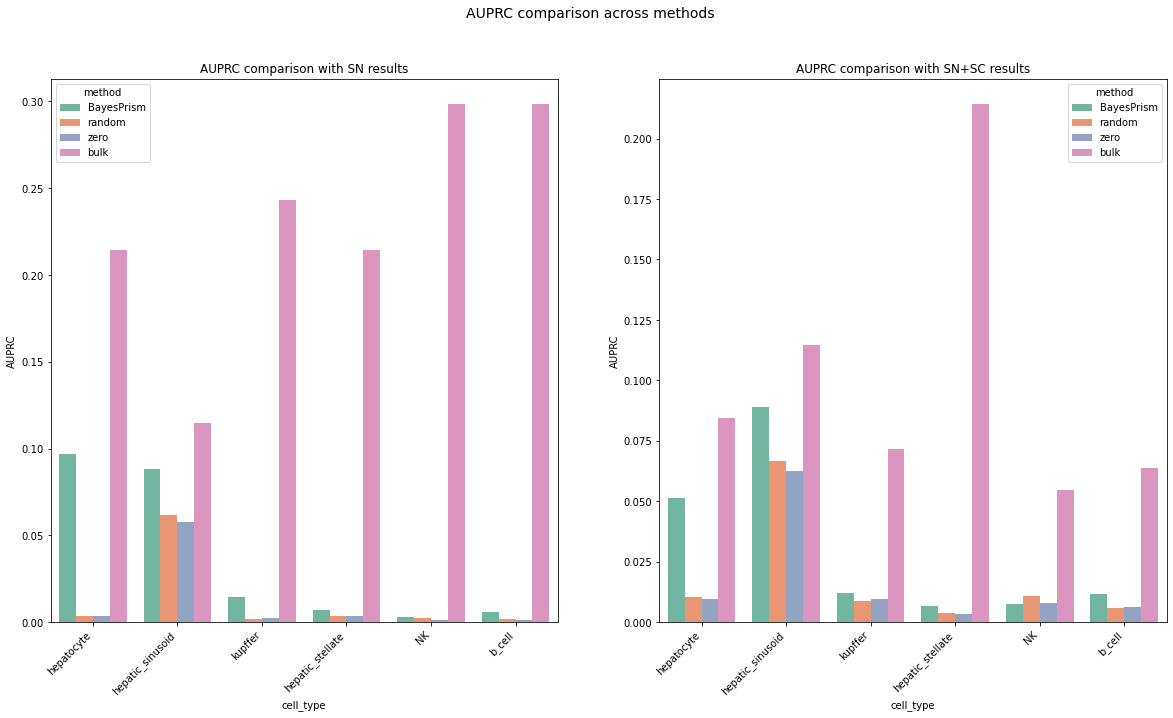

In [58]:

# plot
fig, axs = plt.subplots(1, 2, figsize=(20,10))

sns.barplot(data=all_res_df[all_res_df["ref_set"] == "sn"], 
            x="cell_type", y="scores",
            hue="method", ax= axs[0])
axs[0].set_title("AUPRC comparison with SN results")
axs[0].set(ylabel="AUPRC")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')


sns.barplot(data=all_res_df[all_res_df["ref_set"] == "sc_sn"], 
            x="cell_type", y="scores",
            hue="method", ax= axs[1])
axs[1].set_title("AUPRC comparison with SN+SC results")
axs[1].set(ylabel="AUPRC")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


fig.suptitle("AUPRC comparison across methods", fontsize=14)

fig.show()



### write out results table

In [59]:
out_res_path = Path(f"{res_data_path}/BP_auprc.csv")  

all_res_df.to_csv(out_res_path)  